In [44]:
import torchvision.transforms as transforms
from torchvision import datasets
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import os
from PIL import Image
from PIL import UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
class Incidents12(datasets.VisionDataset):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)

        self.data = []
        self.targets = []
        self.errors = []

        # Load images from disk
        self.classes = os.listdir(root)[1:]
        paths = [root + self.classes[i] + '/' for i in range(len(self.classes))]

        for p in paths:
            for _, _, files in os.walk(p):
                for filename in files:
                    try:
                        img = Image.open(p+filename).convert("RGB")
                        self.data.append(img)
                        self.targets.append(paths.index(p))
                    except (UnidentifiedImageError, FileNotFoundError):
                        self.errors.append(p+filename)
        # Resampling to equalize the amount of samples per class

        #classes_count = {i: 0 for i in range(len(self.classes))}
        #for target in self.targets:
        #    classes_count[target] += 1
        #max_class = max(classes_count, key=classes_count.get)

        #df = pd.DataFrame(data={"Image": self.data, "Label": self.targets})
        #samples_class = [df[df["Label"] == i] for i in range(len(self.classes))]
        #classes_over = [samples_class[i].sample(df[df["Label"] == max_class].shape[0],replace=True) for i in range(len(self.classes))]
        #new_df = pd.concat(classes_over, axis=0).reset_index()

        #self.data = new_df["Image"]
        #self.targets = new_df["Label"]

    def __getitem__(self, index: int): 
        img, target = self.data[index], self.targets[index]

        if self.transform is not None:
            img = self.transform(img)
            img = img.numpy().transpose((1,2,0))

        return img, target

    def __len__(self):
        return(len(self.data))

    def to_dataframe(self):
        tensor_images = [self[i][0] for i in range(len(self.data))]
        return(pd.DataFrame(data={"Image": tensor_images, "Label": self.targets}))

In [3]:
os.listdir("datasets/incidents")

['.ipynb_checkpoints',
 'ice storm',
 'car accident',
 'oil spill',
 'wildfire',
 'earthquake',
 'airplane accident',
 'volcanic eruption',
 'collapsed',
 'tornado',
 'nuclear explosion',
 'bicycle accident',
 'flooded']

In [4]:
transform = transforms.Compose([
    # resize
    transforms.Resize(256),
    # center-crop
    transforms.CenterCrop(224),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.04544269, 0.04544269, 0.04544269],
                         [0.21317291, 0.21317291, 0.21317291])
])

In [5]:
dataset = Incidents12("datasets/incidents/", transform=transform)

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataset.data,dataset.targets,test_size=0.33,random_state=42,
                                                    stratify = dataset.targets)
class_sample_count = np.unique(dataset.targets, return_counts=True)[1]
weights = 1 / torch.Tensor(class_sample_count)

samples_weight = np.array([weights[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [7]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [8]:
print(len(train_dataset))
print(len(test_dataset))

5886
1472


In [31]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, sampler=sampler, num_workers=4)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, num_workers=4)

In [10]:
def imshow(inp, title=None):
    inp = np.array(inp)
    mean = np.array([0.04544269, 0.04544269, 0.04544269])
    std = np.array([0.21317291, 0.21317291, 0.21317291])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [11]:
df = dataset.to_dataframe()

In [12]:
len(df)

7358

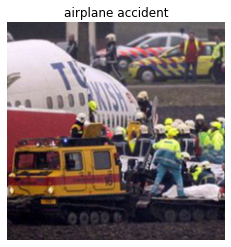

In [13]:
import random
r = random.randint(0,len(dataset.data))
imshow(df["Image"][r], dataset.classes[df["Label"][r]])

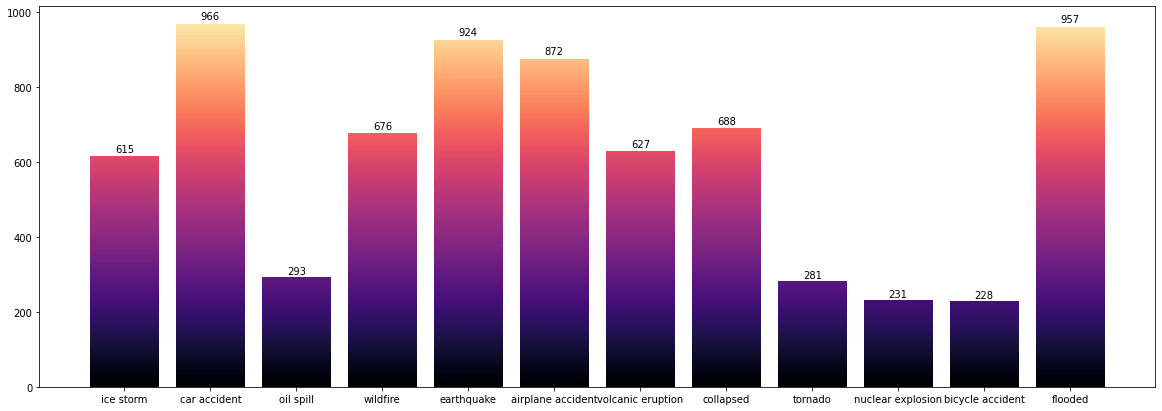

In [14]:
fig, ax = plt.subplots(1,1,figsize=(20,7))
rects = plt.bar(dataset.classes,df["Label"].value_counts().sort_index())

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*height, '%d'%int(height),
                ha='center', va='bottom')
autolabel(rects)

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0, origin='lower',
                  vmin=ymin, vmax=ymax, cmap='magma')
    ax.axis([xmin, xmax, ymin, ymax])

gradientbars_sliced(rects)
plt.show()

The dataset is clearly imbalanced : we are going to oversample using the weights of each category.

 ### Building the Neural network model

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda

In [32]:
import torch.nn as nn
from torchvision import models

alexnet = models.alexnet(pretrained=True)

## freeze the layers
for param in alexnet.parameters():
    param.requires_grad = False
    
# Modify the last layer
number_features = alexnet.classifier[6].in_features
features = list(alexnet.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, len(dataset.classes))])
alexnet.classifier = torch.nn.Sequential(*features)

alexnet = alexnet.to(device)
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [33]:
criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

In [34]:
import time
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        train_loss = 0

        # Iterate over data.
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.permute(0,3,2,1)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs  = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        print('{} loss: {:.4f}'.format(
               'Train', train_loss / train_size))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))

    return model

In [35]:
alexnet = train_model(alexnet, criterion, optimizer_ft, num_epochs=25)

----------
Epoch 0/24
Train loss: 1.3992
----------
Epoch 1/24
Train loss: 0.9635
----------
Epoch 2/24
Train loss: 0.7180
----------
Epoch 3/24
Train loss: 0.5794
----------
Epoch 4/24
Train loss: 0.4244
----------
Epoch 5/24
Train loss: 0.3790
----------
Epoch 6/24
Train loss: 0.2932
----------
Epoch 7/24
Train loss: 0.2511
----------
Epoch 8/24
Train loss: 0.2020
----------
Epoch 9/24
Train loss: 0.1513
----------
Epoch 10/24
Train loss: 0.1293
----------
Epoch 11/24
Train loss: 0.1105
----------
Epoch 12/24
Train loss: 0.0794
----------
Epoch 13/24
Train loss: 0.0715
----------
Epoch 14/24
Train loss: 0.0647
----------
Epoch 15/24
Train loss: 0.0609
----------
Epoch 16/24
Train loss: 0.0448
----------
Epoch 17/24
Train loss: 0.0523
----------
Epoch 18/24
Train loss: 0.0354
----------
Epoch 19/24
Train loss: 0.0310
----------
Epoch 20/24
Train loss: 0.0289
----------
Epoch 21/24
Train loss: 0.0271
----------
Epoch 22/24
Train loss: 0.0280
----------
Epoch 23/24
Train loss: 0.0355
--

### Testing the model

In [36]:
correct = 0
total = 0
alexnet.eval()

with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0,3,2,1)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of Alexnet algorithm over the training set of {} images : {}%.".format(len(trainloader), 100*correct/total))

Accuracy of Alexnet algorithm over the training set of 1233 images : 99.67539054574965%.


In [37]:
correct = 0
total = 0
alexnet.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0,3,2,1)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of Alexnet algorithm over the testing set of {} images : {}%.".format(len(testloader), 100*correct/total))

Accuracy of Alexnet algorithm over the testing set of 368 images : 67.52717391304348%.


In [38]:
def viz_images(model, n_preds=8):
    n_preds += n_preds%4
    n_cols = 4
    n_rows = n_preds//n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,7))
    plt.subplots_adjust(bottom=1.8, top=3)
    
    was_training = model.training
    model.eval()
    i = 0
    with torch.no_grad():
        for (_, data) in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.permute(0,3,2,1)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            inputs = inputs.permute(0,3,2,1)
            for j in range(n_cols):
                inp = np.array(inputs.cpu().data[j])
                mean = np.array([0.04544269, 0.04544269, 0.04544269])
                std = np.array([0.21317291, 0.21317291, 0.21317291])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                axs[i][j].set_title('predicted: {}'.format(dataset.classes[preds[j]]))
                axs[i][j].imshow(inp) 
                if 4*i+j == n_preds:
                    model.train(mode=was_training)
                    return
            i += 1
            if i == n_rows:
                return
        model.train(mode=was_training)

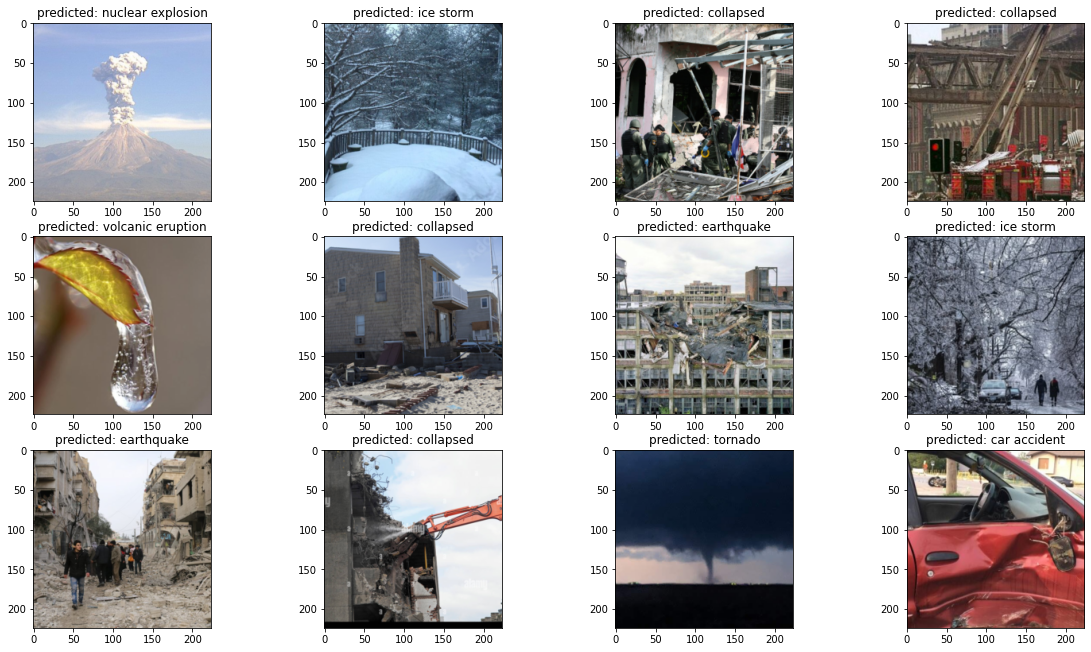

In [41]:
viz_images(alexnet,12)

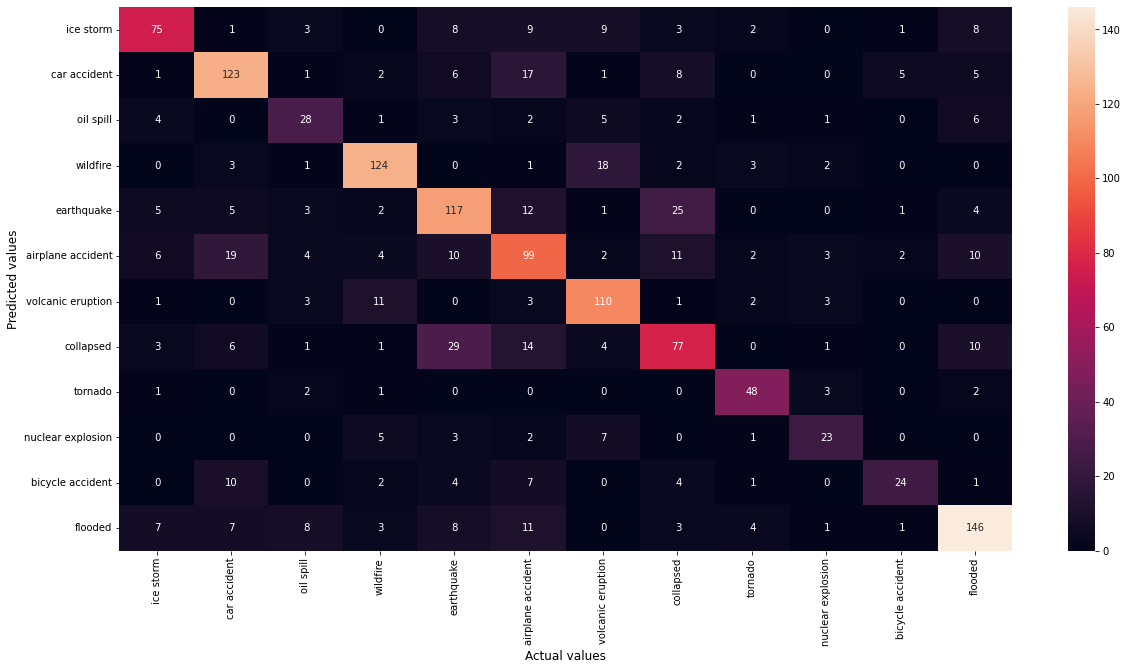

In [42]:
y_pred = []
y_true = []

# iterate over test data
for data in testloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    inputs = inputs.permute(0,3,2,1)
    labels = labels.data.cpu().numpy()
    
    output = alexnet(inputs) 
    output = torch.max(output, 1)[1].data.cpu().numpy()
    
    y_pred.extend(output) 
    y_true.extend(labels) 

classes = dataset.classes

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])

fig, ax = plt.subplots(figsize = (20,10))
s = sn.heatmap(df_cm, annot=True, fmt='2')
s.set_xlabel('Actual values', fontsize=12)
s.set_ylabel('Predicted values', fontsize=12)
plt.show()

In [46]:
print(classification_report(y_true, y_pred,target_names=dataset.classes))

                   precision    recall  f1-score   support

        ice storm       0.73      0.63      0.68       119
     car accident       0.71      0.73      0.72       169
        oil spill       0.52      0.53      0.52        53
         wildfire       0.79      0.81      0.80       154
       earthquake       0.62      0.67      0.64       175
airplane accident       0.56      0.58      0.57       172
volcanic eruption       0.70      0.82      0.76       134
        collapsed       0.57      0.53      0.55       146
          tornado       0.75      0.84      0.79        57
nuclear explosion       0.62      0.56      0.59        41
 bicycle accident       0.71      0.45      0.55        53
          flooded       0.76      0.73      0.75       199

         accuracy                           0.68      1472
        macro avg       0.67      0.66      0.66      1472
     weighted avg       0.68      0.68      0.67      1472



### VGG Model

In [67]:
vgg16 = models.vgg16(pretrained=True)
## freeze the layers
for param in vgg16.parameters():
    param.requires_grad = False
    
# Modify the last layer
number_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, len(dataset.classes))])
vgg16.classifier = torch.nn.Sequential(*features)

vgg16 = vgg16.to(device)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [68]:
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
vgg16 = train_model(vgg16, criterion, optimizer, num_epochs=10)

----------
Epoch 0/9
Train loss: 0.8270
----------
Epoch 1/9
Train loss: 0.5516
----------
Epoch 2/9
Train loss: 0.4156
----------
Epoch 3/9
Train loss: 0.3564
----------
Epoch 4/9
Train loss: 0.2828
----------
Epoch 5/9
Train loss: 0.2566
----------
Epoch 6/9
Train loss: 0.2312
----------
Epoch 7/9
Train loss: 0.1896
----------
Epoch 8/9
Train loss: 0.1776
----------
Epoch 9/9
Train loss: 0.1516
Training complete in 6m 29s


In [71]:
correct = 0
total = 0
vgg16.eval()

with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0,3,2,1)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of VGG algorithm over the training set of {} images : {}%.".format(len(trainloader), 100*correct/total))

Accuracy of VGG algorithm over the training set of 1233 images : 96.12497463988639%.


In [70]:
correct = 0
total = 0
vgg16.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0,3,2,1)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of VGG algorithm over the testing set of {} images : {}%.".format(len(testloader), 100*correct/total))

Accuracy of VGG algorithm over the testing set of 368 images : 67.86684782608695%.


### Inception

In [77]:
inception = models.inception_v3(pretrained=True)
## freeze the layers
for param in inception.parameters():
    param.requires_grad = False
    
# Modify the last layer
number_features = inception.fc.in_features
features = list(inception.fc.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, len(dataset.classes))])
inception.fc = torch.nn.Sequential(*features)

inception = inception.to(device)
inception.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [79]:
optimizer_inception = optim.SGD(inception.parameters(), lr=0.001, momentum=0.9)
inception = train_model(inception, criterion, optimizer_inception, num_epochs=10)

----------
Epoch 0/9
Train loss: 0.9831
----------
Epoch 1/9
Train loss: 0.6909
----------
Epoch 2/9
Train loss: 0.5328
----------
Epoch 3/9
Train loss: 0.5126
----------
Epoch 4/9
Train loss: 0.4118
----------
Epoch 5/9
Train loss: 0.3883
----------
Epoch 6/9
Train loss: 0.3391
----------
Epoch 7/9
Train loss: 0.3206
----------
Epoch 8/9
Train loss: 0.2862
----------
Epoch 9/9
Train loss: 0.2765
Training complete in 7m 56s


In [80]:
correct = 0
total = 0
inception.eval()

with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0,3,2,1)
        outputs = inception(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of Inception algorithm over the training set of {} images : {}%.".format(len(trainloader), 100*correct/total))

Accuracy of Inception algorithm over the training set of 1233 images : 91.96591600730372%.


In [81]:
correct = 0
total = 0
inception.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.permute(0,3,2,1)
        outputs = inception(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of Inception algorithm over the testing set of {} images : {}%.".format(len(testloader), 100*correct/total))

Accuracy of Inception algorithm over the testing set of 368 images : 63.51902173913044%.
